<a href="https://colab.research.google.com/github/castudil/som-lstm/blob/main/DTW-SOM/DTW_SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [1]:
## éste paquete utiliza mini som por debajo
!pip install DtwSom


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import dtwsom   # Librería para utilizar el modelo DTW-SOM
import os
import numpy as np  
import pandas as pd
import pickle # Librería que serializa y deserializa una estructura de objetos Python
from math import sqrt

from sklearn.preprocessing import MinMaxScaler # función para el escalar los datos
from sklearn.cluster import KMeans 

from tslearn.metrics import dtw # Distancia DTW (dynamic time wrapping)

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from matplotlib import cm

from scipy.spatial.distance import cdist # calcula distancias Manhattan(cityblock)



# Funciones

In [3]:
def perturbation(df, col=0, mu=0, sigma=0.1):

  """
    Funcion que perturba una columna de un dataframe, con una cantidad 
    normalmente distribuida con media 0 y desviación típica 0,1 por defecto.

    Parameters
        -----------
        df : DataFrame 
          DataFrame de los datos para perturbar
        col : int
          columna del DataFrame que sera perturbada
        mu: float
          mean
        sigma: float
          desviacion estandar
  """
  np.random.seed(11)
  df = df.copy() # copia el dataframe para evitar que se modifique el dataframe original

  cardinality = df.shape[0] # numero de instancias del dataset

  # Toma muestras aleatorias de una distribución normal
  perturbacion = pd.Series(np.random.normal(loc=mu, scale=sigma, size=cardinality))

  columns_name  = df.columns # nombres de las columnas

  # Suma las muestras aleatorias a la columna seleccionada y pasa esta suma al dataset copiado.
  df[columns_name[col]] = df[columns_name[col]] + perturbacion  

  return df

In [4]:
def perturbationByInstance(instance, num_muta=100, mu=0, sigma=0.1):
    """
    Función que genera perturbaciones de una instancia dada, con una cantidad 
    normalmente distribuida con media 0 y desviación típica 0,1 por defecto.

    Parameters
        -----------
    instance : np.array
        instancia que será perturbada
    num_muta : int
        cantidad de perturbaciones a generar
    mu: float
        mean
    sigma: float
        desviación estándar
    """
    df =[] # inicia el array 

    cardinality = instance.shape[0] # numero de columnas de la instancia

    # Genera n mutaciones de la instancia dada.
    for i in range(num_muta):
        # Toma muestras aleatorias de una distribución normal
        noise = pd.Series(np.random.normal(loc=mu, scale=sigma, size=cardinality))
        # suma el ruido a las instancia en particular
        element = np.array(instance + noise) 
        # Agrega la instancia perturbada a lista de instancias mutadas
        df.append(element)

    return np.array(df)

In [5]:
def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.
    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return np.sqrt(np.dot(x, x.T))

# Dataset PM25

Carga el conjunto de datos de material particulado menor a 2.5 micras de 9 regiones, del valle central de Chile. 

In [6]:
#path = '/Users/igarciao/Documents/som-lstm/data/' # use your path
path = 'https://raw.githubusercontent.com/castudil/som-lstm/main/data/' # use your path
cities = ['chillan','curico','linares','los_angeles','osorno','puerto_montt','rancagua','san_fernando','talca'];
li = []
for i in cities:
  filename=path+i+'.csv'
  print('loading: '+filename)
  df = pd.read_csv(filename, index_col=None, header=0)
  # Convert the date column to a datestamp type
  df['date'] = pd.to_datetime(df['date'])
  # Set the date column as the index of your DataFrame meat
  df['city']=i
  df = df.set_index('date')
  #print(df.head(5))
  li.append(df)

print('consolidating into a single data frame.')
frame = pd.concat(li, axis=0, ignore_index=False)
print('displaying a random sample.')
print(frame.sample(n = 15))
print(frame.describe())
print(frame.index.min())
print(frame.index.max())

loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/chillan.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/curico.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/linares.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/los_angeles.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/osorno.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/puerto_montt.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/rancagua.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/san_fernando.csv
loading: https://raw.githubusercontent.com/castudil/som-lstm/main/data/talca.csv
consolidating into a single data frame.
displaying a random sample.
                        PM25          city
date                                      
2018-10-30 06:00:00    0.000  san_fernando
2017-05-13 04:00:00    5.000  puerto_montt
20

Para aprobar en primera instancia el algoritmo nos centraremos solo en la ciudad de Talca.

In [7]:
# filtered for city
df_talca = frame.loc[frame['city'] == 'talca']
del(df_talca['city'])
df_talca.shape

(43847, 1)

Se puede observar que el conjunto para la ciudad de Talca es de 43847 instancias, que representan el PM2.5 por hora entre los años 2016 y 2022. Este sera transformado en un formato de ventanas de 24 horas, Quedando con el formato (n, 24) donde n representa  a las días entre las fechas indicadas anteriormente.

el paper DTW SOM [CITA] muestra un procedimineto similar, donde se hacen ventanas de 24 horas.

corta todos los datos a series de tiempo de 24 horas de igual dimension. las ventanas no se solapan.


In [8]:
def create_window_data(df):
  data = []
  index= []
  for i in range(0, int(df.size /24) ):
    index.append(np.array(df.index[i*24:i*24+24]).reshape(1,24)[0])
    data.append(df.values[i*24:i*24+24].reshape(1,24)[0])

  data = np.array(data) ## serie de tiempo
  index = np.array(index) ### este indice identifica el dia

  return (data, index)

data_talca, index_talca = create_window_data(df_talca)

data_talca.shape

(1826, 24)

Las observaciones al ser transformada al formato de ventanas de 24 horas, quedaron con un total de 1826 días para analizar.

In [10]:
index_talca[930]

array(['2018-07-19T01:00:00.000000000', '2018-07-19T02:00:00.000000000',
       '2018-07-19T03:00:00.000000000', '2018-07-19T04:00:00.000000000',
       '2018-07-19T05:00:00.000000000', '2018-07-19T06:00:00.000000000',
       '2018-07-19T07:00:00.000000000', '2018-07-19T08:00:00.000000000',
       '2018-07-19T09:00:00.000000000', '2018-07-19T10:00:00.000000000',
       '2018-07-19T11:00:00.000000000', '2018-07-19T12:00:00.000000000',
       '2018-07-19T13:00:00.000000000', '2018-07-19T14:00:00.000000000',
       '2018-07-19T15:00:00.000000000', '2018-07-19T16:00:00.000000000',
       '2018-07-19T17:00:00.000000000', '2018-07-19T18:00:00.000000000',
       '2018-07-19T19:00:00.000000000', '2018-07-19T20:00:00.000000000',
       '2018-07-19T21:00:00.000000000', '2018-07-19T22:00:00.000000000',
       '2018-07-19T23:00:00.000000000', '2018-07-20T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [11]:
data_talca[930] ###TODO cambiar a nombre significativo

array([35., 21., 14., 14., 14., 12., 12., 14., 27., 41., 35., 39., 43.,
       45., 28., 28., 40., 39., 59., 60., 55., 52., 58., 34.])

Se puede observar como estaría conformada una ventana de 24 horas de nuestros datos.

# Inicializacion de parametros para SOM

Una regla general para establecer el tamaño de la rejilla para una tarea de reducción de la dimensionalidad es que debe contener 5*raiz(N) neuronas donde N es el número de muestras del conjunto de datos a analizar. 

Por ejemplo, si su conjunto de datos tiene 150 muestras, 5*sqrt(150) = 61,23 por lo que un mapa de 8 por 8 debería funcionar bien.

Recomendación entrega por el paquete de MiniSOm (https://github.com/JustGlowing/minisom/blob/b18aa5cb293ab99c2d77f37d312b12d7d93d2124/minisom.py#L528)

In [12]:
round(sqrt(5*sqrt(len(data_talca))))

15

TODO: EXPLICAR COMPARACIÓN (experimento) aquí se debe explicar cómo se va a realizar el experimento, pero por sobre todo el por qué. Esto quiere decir que hay que dar las razones del por qué queremos comparar el son tradicional con la versión que utiliza DTW. Se podría dejar por escrito también cuál es el resultado esperados

El experimento presenta una comparación de un SOM tradicional con una variante que utiliza DTW, llamada DTW-SOM. Se compara los dos métodos con los mismos datos y con configuraciones similares. Se espera obtener que la version que utiliza DTW tenga un menor error de cuantificación, puesto que, en los análisis realizados por [paper] se obtenían mejores resultados al encontrar similitudes en datos de series temporales. 

La comparación es necesaria para proponer un método que represente mejor los datos de entradas con el fin de obtener una mejor preservación de la topología, probando la robustez de los modelos propuestos.

In [15]:
# Inicializa los parametros de SOM
num_neurons = round(sqrt(5*sqrt(len(data_talca))))
sigma = 3 # radio
lr = 0.5 # tasa de aprendizaje
seed = 11 # semilla para repetir los resultados
num_iter = 5000 # numero de iteraciones para entrenar al SOM
input_len = data_talca.shape[1] #Largo de la entrada

# Parámetros específicos SOM estándar
dist = 'euclidean' # Distancia utilizada 
neighborhood_funct = 'gaussian' # funcion de vencidad 

# Parámetros específicos de DTW-SOM
gl_const="sakoe_chiba"
scr=60


# DTW-SOM

Carga el modelo DTW-SOM ya entrenado con los parametros indicados en el punto anterior.

Entrena a DTW-SOM en el caso de no tener un modelo pre-entrenado.

TODO: ACTUALIZAR PARA QUE FUNCIONE ONLINE

TODO: AVERIGUAR COMO CARGAR MODELOS Y DEJAR CODIGO COMENTADO

In [17]:
if os.path.exists('dtw_som_15.pkl'):
    with open('dtw_som_15.pkl', 'rb') as f:
        dtw_som = pickle.load(f)
else:
    dtw_som = dtwsom.DtwSom(num_neurons, num_neurons, input_len, sigma=sigma, learning_rate=lr,
                        random_seed=seed, gl_const=gl_const, scr=scr)
    dtw_som.pca_weights_init(data_talca)
    dtw_som.train_batch(data_talca, num_iter, verbose=True)

NameError: ignored

In [ ]:
weights = dtw_som.get_weights()
print("cuantificacion del error: ",dtw_som.quantization_error(data_talca))

cuantificacion del error:  28.437137390020354


## Save Model

Guarda el modelo DTW-SOM en el archivo "dtw_som.pkl" para no tener que volver a entrenar el modelo.

In [ ]:
## Save the model so that you do not need to train it again
with open('dtw_som_15.pkl', 'wb') as f:
    pickle.dump(dtw_som,f)

## Agrupación 

In [ ]:
KMeans_X = np.stack((np.array(weights)).reshape(num_neurons*num_neurons, 24))
KMeans_all = KMeans(n_clusters=4, random_state=11).fit(KMeans_X)


In [ ]:
def graph_cluster(data,W,num_neurons, maxylim=150):
    plt.figure(figsize=(20, 20))
    norm = Normalize(vmin=0, vmax=3, clip=True)
    cmap = ListedColormap(["#f1faee", '#e63946', "#f9c74f", '#a8dadc'])
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    for i in range(num_neurons):
        for j in range(num_neurons):
            ax = plt.subplot(num_neurons, num_neurons, i*num_neurons + 1+j)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_ylim((0,maxylim/5))
            plt.plot(W[ i, j, :].T, color= 'black')
            ax.set_facecolor(mapper.to_rgba(data.labels_[i*num_neurons +j]))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

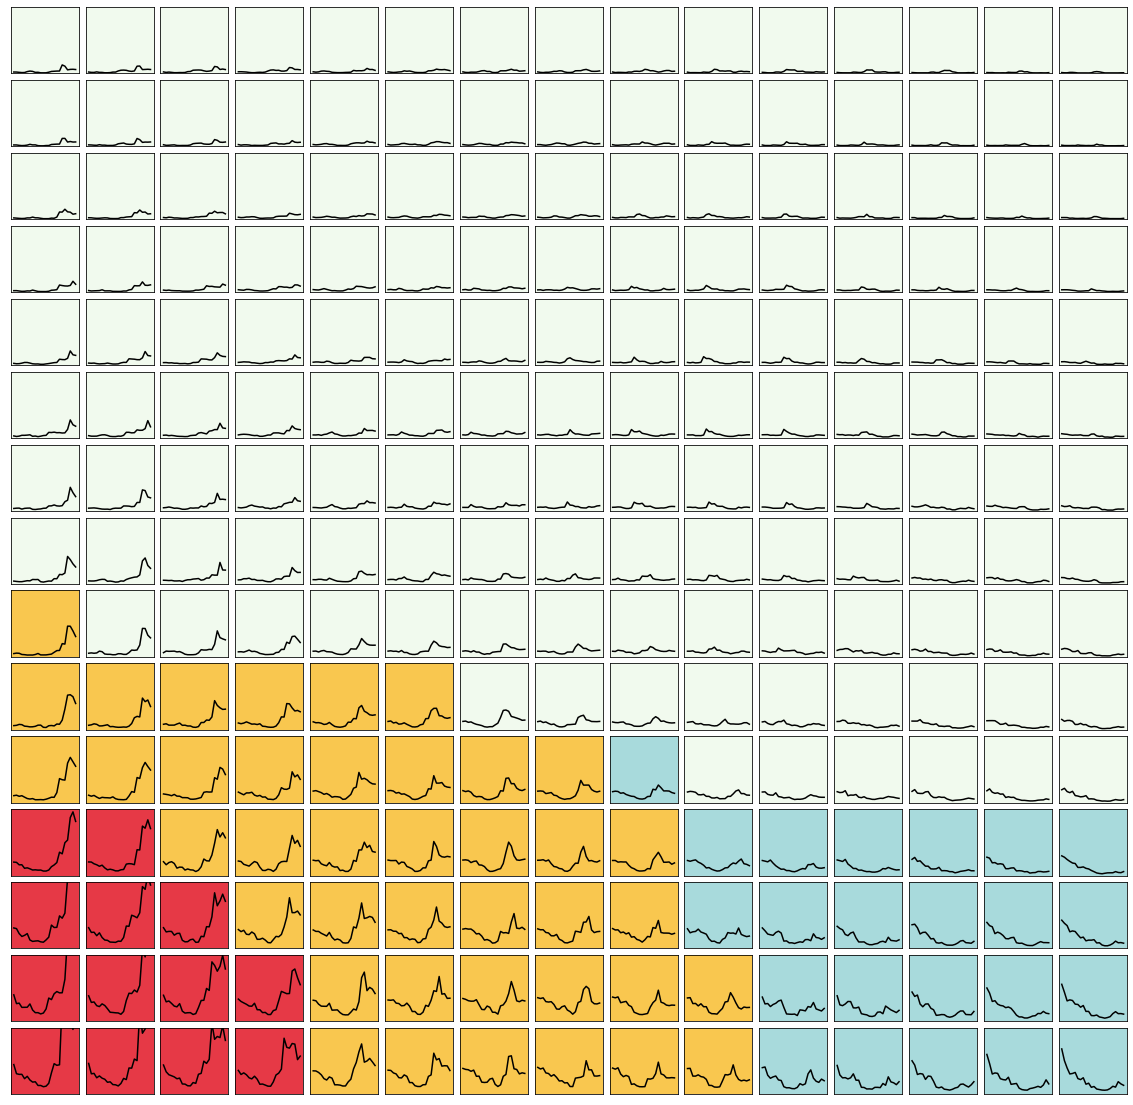

In [ ]:
graph_cluster(data=KMeans_all,W=weights,num_neurons=num_neurons, maxylim=np.max(data_talca))

Al agrupar en 4 cluster las series temporales, se espera encontrar agrupaciones que representan los periodos estacionales como verano, invierno, primavera y otoño. Al observar los cluster obtenidos podemos encontrar series que presentan una curva más pronunciada, indicando que el PM25 es mayor para esa zona color roja, por lo que, se puede inducir que ésta es representativa al periodo de Invierno. De esta manera podemos identificar otras estaciones, como la zona amarilla, en la cual tenemos series con curvas menos pronunciada, pero con montes significativos que podemos asociarlo al otoño. por otro lado la zona celeste es similar a la primavera, donde la contaminación va reduciendo a medida que vamos acercándonos al verano. Los series que presentan un patron más aplanado son asociadas a bajas concentraciones de pm25, el cual podemos encontrar en verano, siendo representados en la agrupación por la zona blanca. Kmeans consigue agrupar las series que presentan patrones de pm25 similares para los diferentes periodos de tiempo.

## Visualización de los pesos 

In [ ]:
def graph_weights(W, num_neurons, save_img=False):
    plt.figure(figsize=(15, 16))

    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.title("PM25 " +"- "+str(i+1)+" hour")
        plt.pcolor(W[:,:,i].T,cmap='coolwarm')
        plt.colorbar()
    plt.tight_layout()
    if save_img:
        plt.savefig('images/som_weights.png')
    plt.show()


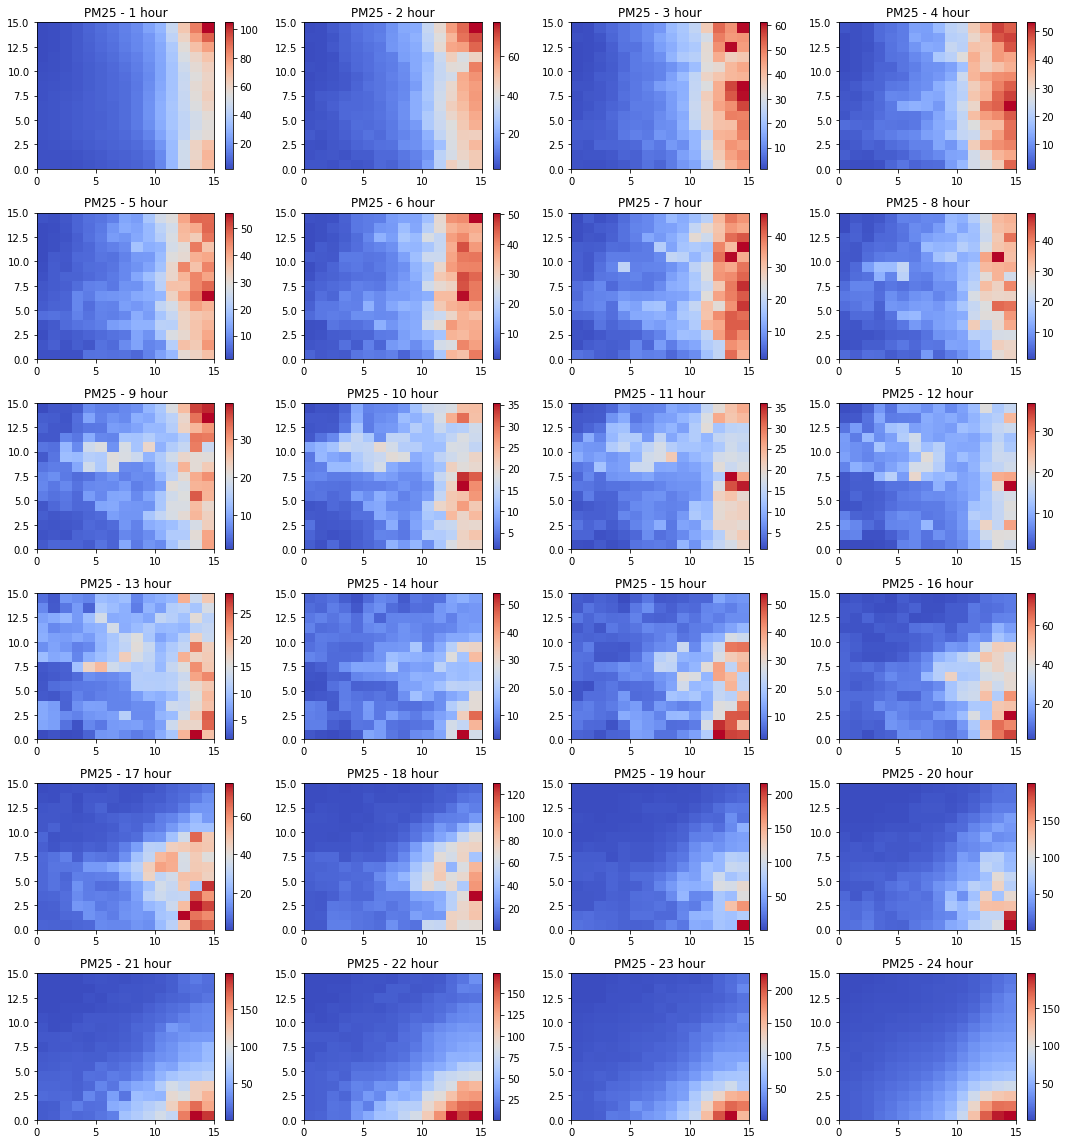

In [ ]:
graph_weights(weights, num_neurons, True)

In [ ]:
def graph_u_matrix(data):
    plt.figure(figsize=(8, 8))
    plt.pcolor(data, cmap='coolwarm', alpha=.35)
    plt.colorbar()

    colors = ['C3', 'C2', "C1"]

    #plt.legend(loc='upper right')
    plt.grid()
    #plt.savefig('resulting_images/som_seed.png')
    plt.show()

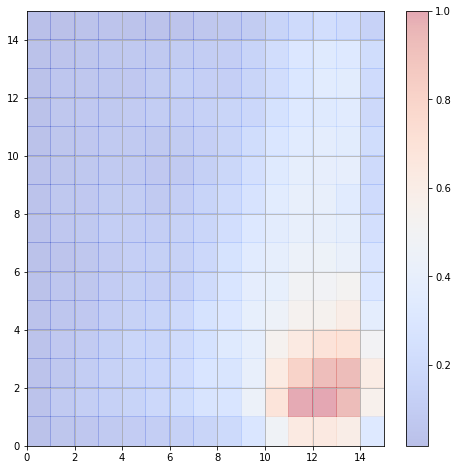

In [ ]:
graph_u_matrix(dtw_som.distance_map().T)

# SOM - standard

In [ ]:
# Inicializa SOM
som_standard = dtwsom.MiniSom(num_neurons, num_neurons, input_len, sigma=sigma, learning_rate=lr,
                    random_seed=seed)
som_standard.pca_weights_init(data_talca)
som_standard.train_batch(data_talca, num_iter, verbose=True) # Entrada SOM


 [ 3000 / 3000 ] 100% - 9013.93 it/s - 0:00:00 left  - quantization error: 40.970833905619706


In [ ]:
with open('som_standard.pkl', 'rb') as f:
    som_standard = pickle.load(f)

In [ ]:
weights = som_standard.get_weights() # Obtiene los pesos
print("cuantificacion del error: ",som_standard.quantization_error(data_talca))

cuantificacion del error:  40.970833905619706


In [ ]:
## Save the model so that you do not need to train it again
with open('som_standard_15.pkl', 'wb') as f:
    pickle.dump(som_standard,f)

# Comparativa SOM estándar y DTW-SOM

Se compara

# Pruebas

Experimento 1 : 
* Paso 1: tomar una instacia x y generar m mutantes,
* Paso 2: Identificar la neurona que representa a a la instacia x.
* paso 3: Para cada mutante hacer : Identificar a la neurona que representa a la mutante.
* Paso 4: El error es igual a la distancia que existe entre la neurona que representa a x y la neurona que representa a la mutante.
* Paso 5: reportar el error acumulado
 
 Comporar SOm y DTW-SOM usando experimento 1

 Supuesto preliminar:

 * DTW_SOM tiene menos error 
 * La estadistica representa a mas de x. 


# Experimento 1

In [ ]:
def graph_perturbation_u_matrix(som,instance, ins_perturbate, data=[], show_data=False, col_names=[], show_target=False, jitter=True ,save_img=False, name_image='som_seed_pert'):
    w_x, w_y = zip(*[som.winner(d) for d in ins_perturbate]) ## obtener coordenadas de las perturbaciones
    w_x = np.array(w_x) ## vectores de las columnas de todas las neuronas que representan a las perturbaciones.
    w_y = np.array(w_y) ## idem para filas en la malla SOM

    w_x_ins, w_y_ins = zip(*[som.winner(instance)]) ### coordenadas de la BMU
    w_x_ins = np.array(w_x_ins)
    w_y_ins = np.array(w_y_ins)


    plt.figure(figsize=(10, 10))
    plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
    plt.colorbar()

    colors = ['#0081a7', '#ff70a6', '#a7c957']

    if show_data:
        w_x_data, w_y_data = zip(*[som.winner(d) for d in data]) ## obtener coordenadas de los datos
        w_x_data = np.array(w_x_data) ## vectores de las columnas de todas las neuronas.
        w_y_data = np.array(w_y_data) ## idem para filas en la malla SOM
        if show_target:
            for c in np.unique(target):
                idx_target = target==c
                plt.scatter(w_x_data[idx_target]+(.5+(np.random.rand(np.sum(idx_target))-.5)*.8 if jitter else 0),
                            w_y_data[idx_target]+(.5+(np.random.rand(np.sum(idx_target))-.5)*.8 if jitter else 0), 
                            s=15, c=colors[c], label=label_names[c], alpha=.6)
        else:
            plt.scatter(w_x_data+(.5+(np.random.rand(data.shape[0])-.5)*.6 if jitter else 0),
                    w_y_data+(.5+(np.random.rand(data.shape[0])-.5)*.6 if jitter else 0), 
                    s=15, c='#888888', label="BMU instance", alpha=.3) 

    plt.scatter(w_x+(.5+(np.random.rand(ins_perturbate.shape[0])-.5)*.6 if jitter else 0),
                w_y+(.5+(np.random.rand(ins_perturbate.shape[0])-.5)*.6 if jitter else 0), 
                s=20, c='#ffbd00', label="BMU Perturbed Instances", alpha=.4) ## rand le da un a especie de Jitter para que no aparezcan en el mimos punto
    plt.scatter(w_x_ins+(.5+(np.random.rand(1)-.5)*.6 if jitter else 0),
                w_y_ins+(.5+(np.random.rand(1)-.5)*.6 if jitter else 0), 
                s=30, c='#d00000', label="BMU query instance", alpha=.8) 

    plt.legend(loc='upper right')
    plt.grid()
    if save_img:
        plt.savefig('images/'+str(name_image)+'.png')
    plt.show()

In [ ]:
def error_acumulado_dtw_som(instancia, modelo,ins_perturbed):

    # 2- Se identifica la neurona que representa a la instancia seleccionada 'x'.
    bmu = modelo.get_weights()[modelo.winner(instancia)] 

    # 3- Para cada instancia perturbada, se identifica a la neurona que la representa.
    bmu_mutantes = [modelo.get_weights()[modelo.winner(ins)] for ins in ins_perturbed]

    #4- Calcula la distancia/error que existe entre la neurona que representa a ´x´ y la neuronas que representa a las mutante.
    error = 0
    for bmu_mutante in bmu_mutantes:
        error += dtw(bmu, bmu_mutante,global_constraint=modelo.gl_const,
                    sakoe_chiba_radius=modelo.scr, itakura_max_slope=modelo.ims)

    # 5- Calcula el error acumulado
    error_acum = error / len(ins_perturbed)

    return  error_acum

In [ ]:
def error_acumulado_som(instancia, modelo,ins_perturbed):
   # 2- Se identifica la neurona que representa a la instancia seleccionada 'x'.
    bmu = modelo.get_weights()[modelo.winner(instancia)] 

    # 3- Para cada instancia perturbada, se identifica a la neurona que la representa.
    bmu_mutantes = [modelo.get_weights()[modelo.winner(ins)] for ins in ins_perturbed]

    #4- Calcula la distancia/error que existe entre la neurona que representa a ´x´ y la neuronas que representa a las mutante.
    distancias = np.array([fast_norm(bmu-bmu_mutante) for bmu_mutante in bmu_mutantes])

    # 5- Calcula el error acumulado
    error_acum = distancias.sum() / len(ins_perturbed)

    return error_acum

In [ ]:
def error_acumulado_som_grid(instancia, modelo, ins_perturbed):
    # 2- Se identifica la neurona que representa a la instancia seleccionada 'x'.
    bmu = [np.asarray(modelo.winner(instancia)).tolist()] # modelo.quantization(np.array([instancia]))[0]

    # 3- Para cada instancia perturbada, se identifica a la neurona que la representa.
    bmu_mutantes = [ [np.asarray(modelo.winner(np.array(ins))).tolist()] for ins in ins_perturbed]

    #4- Calcula la distancia/error que existe entre la neurona que representa a ´x´ y la neuronas que representa a las mutante.
    distancias = np.array([cdist(bmu, bmu_mutante, metric='cityblock') for bmu_mutante in bmu_mutantes])

    # 5- Calcula el error acumulado
    error_acum = distancias.sum() / len(ins_perturbed)

    return error_acum

In [ ]:
def method_validation(instance, ins_perturbed, som_standard=None, dtw_som=None):
        if(som_standard):
                errorE_som_standard= error_acumulado_som(instance, som_standard, ins_perturbed)
                print('Error som standard (Euclidean): ', errorE_som_standard)
                error_som_standard = error_acumulado_som_grid(instance, som_standard, ins_perturbed)
                print('Error som standard (Grid): ', error_som_standard)
        if dtw_som:
                errorE_dtwsom = error_acumulado_som(instance, dtw_som, ins_perturbed)
                print('Error DTW-SOM (Euclidean): ', errorE_dtwsom)
                errorDTW_dtwsom = error_acumulado_dtw_som(instance, dtw_som, ins_perturbed)
                print('Error DTW-SOM (DTW): ', errorDTW_dtwsom)
                error_dtwsom = error_acumulado_som_grid(instance, dtw_som, ins_perturbed)
                print('Error DTW-SOM (Grid): ', error_dtwsom)

In [ ]:
def method_validation_grid(instance, ins_perturbed, som_standard=None, dtw_som=None):
        if(som_standard):
                error_som_standard = error_acumulado_som_grid(instance, som_standard, ins_perturbed)
                print('Error som standard (Grid): ', error_som_standard)
        if dtw_som:
                error_dtwsom = error_acumulado_som_grid(instance, dtw_som, ins_perturbed)
                print('Error DTW-SOM (Grid): ', error_dtwsom)

## Experimento SOM 30x30

In [ ]:
idx_inst =0 
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)

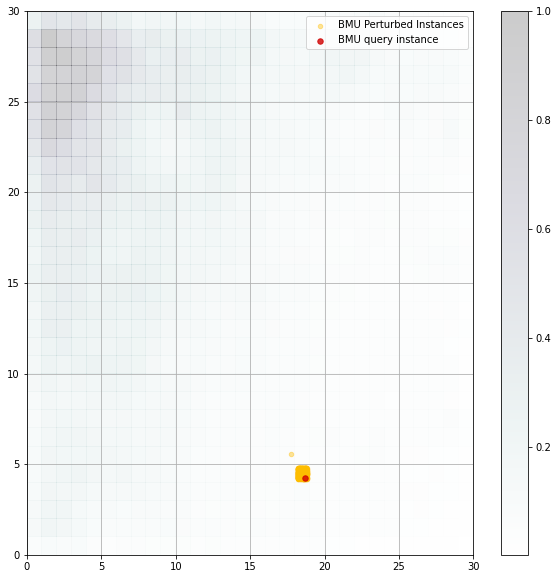

In [ ]:
graph_perturbation_u_matrix(dtw_som, instance, ins_perturbed, jitter=True)

In [ ]:
method_validation(instance, ins_perturbed, som_standard, dtw_som)




Error som standard (Euclidean):  0.0
Error som standard (Grid):  0.0
Error DTW-SOM (Euclidean):  0.02576843058331157
Error DTW-SOM (DTW):  0.00734200081037266
Error DTW-SOM (Grid):  0.006


### instancia anómala 

In [ ]:
idx_inst =391
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)
index_talca[idx_inst][0]

numpy.datetime64('2017-01-26T01:00:00.000000000')

In [ ]:
instance

array([  9.45   ,   9.45   ,   9.85001,   6.82   ,   3.02   ,   5.405  ,
         6.757  ,   5.405  ,   5.405  ,   6.757  ,   6.223  ,   7.196  ,
         8.11   , 410.8    , 447.3    , 525.8    , 766.2    , 602.7    ,
       344.6    , 215.9    , 155.1    ,  67.51   , 147.1    , 112.2    ])

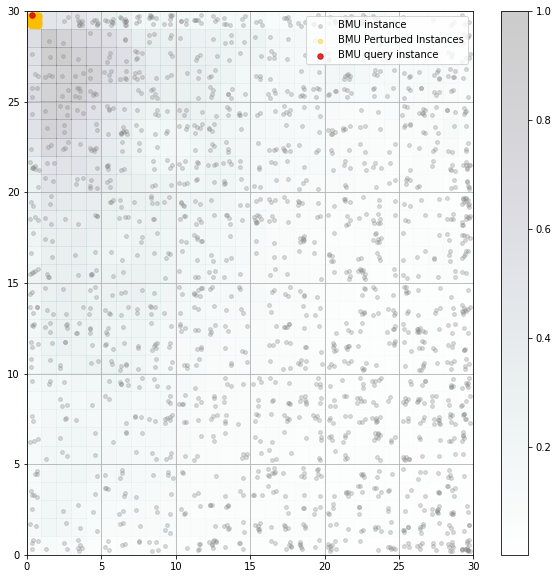

In [ ]:
graph_perturbation_u_matrix(dtw_som, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

In [ ]:
method_validation(instance, ins_perturbed, som_standard, dtw_som)

Error som standard (Euclidean):  0.0
Error som standard (Grid):  0.0
Error DTW-SOM (Euclidean):  0.0
Error DTW-SOM (DTW):  0.0
Error DTW-SOM (Grid):  0.0


### Instancia 520 (2017-06-04 TALCA)

In [ ]:
idx_inst =520
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)
index_talca[idx_inst][0]

numpy.datetime64('2017-06-04T01:00:00.000000000')

In [ ]:
instance

array([ 10.,  15.,  12.,  15.,  20.,  25.,  15.,  26.,  41.,  42.,  29.,
        15.,   4.,   4.,   4.,   7.,  15.,  32.,  29.,  45.,  39.,  45.,
       300., 132.])

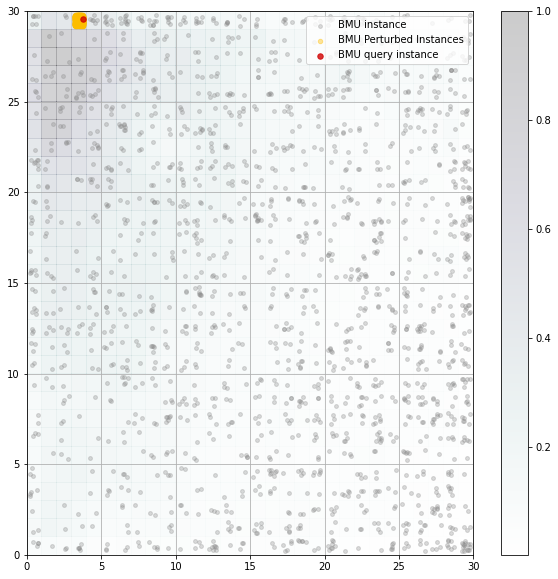

In [ ]:
graph_perturbation_u_matrix(dtw_som, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

In [ ]:
method_validation(instance, ins_perturbed, som_standard, dtw_som)

Error som standard (Euclidean):  0.0
Error som standard (Grid):  0.0
Error DTW-SOM (Euclidean):  0.0
Error DTW-SOM (DTW):  0.0
Error DTW-SOM (Grid):  0.0


## Pruebas SOM 15x15

### Instancia 520 (2017-06-04 TALCA)

In [ ]:
idx_inst =520
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)
index_talca[idx_inst][0]

numpy.datetime64('2017-06-04T01:00:00.000000000')

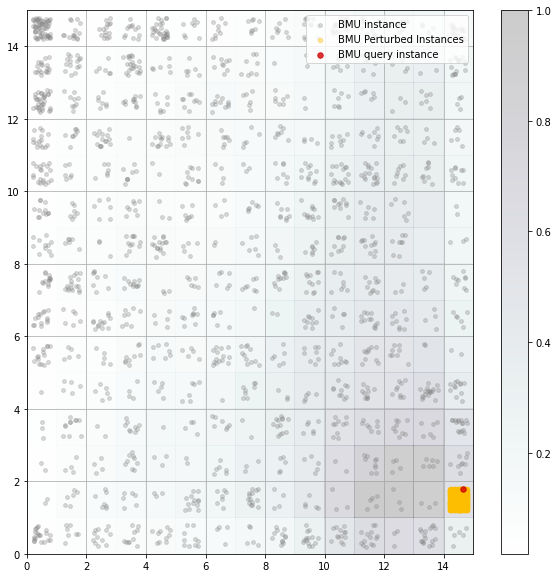

In [ ]:
graph_perturbation_u_matrix(dtw_som, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

In [ ]:
method_validation(instance, ins_perturbed, som_standard, dtw_som)

Error som standard (Euclidean):  0.0
Error som standard (Grid):  0.0
Error DTW-SOM (Euclidean):  0.0
Error DTW-SOM (DTW):  0.0
Error DTW-SOM (Grid):  0.0


### instancia anómala 

In [ ]:
idx_inst =391
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)
index_talca[idx_inst][0]

numpy.datetime64('2017-01-26T01:00:00.000000000')

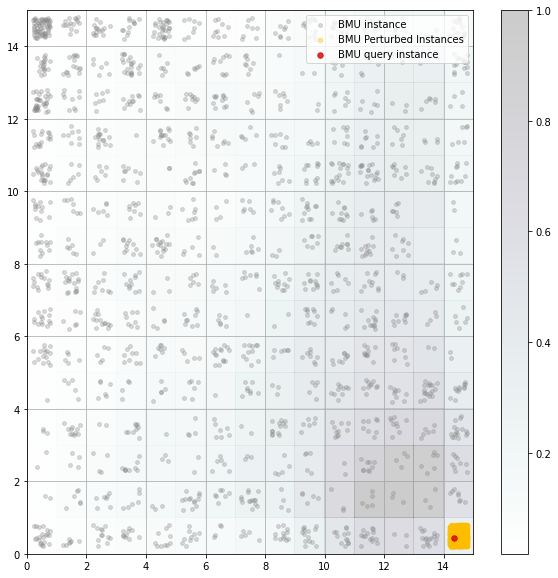

In [ ]:
graph_perturbation_u_matrix(dtw_som, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

In [ ]:
method_validation(instance, ins_perturbed, som_standard, dtw_som)

Error som standard (Euclidean):  0.0
Error som standard (Grid):  0.0
Error DTW-SOM (Euclidean):  0.0
Error DTW-SOM (DTW):  0.0
Error DTW-SOM (Grid):  0.0


### instancia 0

In [ ]:
idx_inst =0 
num_muta=1000
instance= data_talca[idx_inst]
# Generación de instancias perturbadas manualmente
ins_perturbed = perturbationByInstance(instance, num_muta)

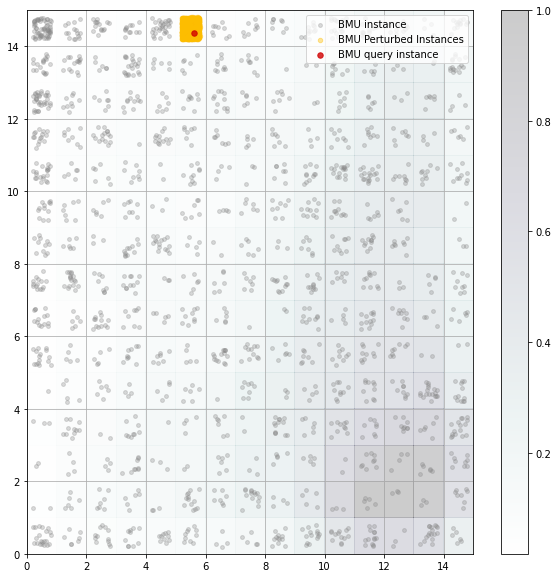

In [ ]:
graph_perturbation_u_matrix(dtw_som, instance, ins_perturbed, jitter=True, data=data_talca, show_data=True)

In [ ]:
method_validation(instance, ins_perturbed, som_standard, dtw_som)

Error som standard (Euclidean):  0.0
Error som standard (Grid):  0.0
Error DTW-SOM (Euclidean):  0.0
Error DTW-SOM (DTW):  0.0
Error DTW-SOM (Grid):  0.0


Experimento

Utilizar instancia atípica para analizar el método  (febrero 2018, incendios)

Buscar instancia 

Describir los resultado obtenidos en los experimento.

